In [26]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os, dill
import anndata
import wot
import pandas as pd
import pegasus as pg

In [13]:
def KL(a, b):
    eps = 1e-16
    return ((a+eps)*np.log((a+eps)/(b+eps))).sum()

def TV(a, b):
    return (np.abs(a - b)*0.5).sum()

In [16]:
# set random seed 
np.random.seed(0)
adata = anndata.read_h5ad("/zfs/users/syz/syz/sde_couplings/data_repr.h5ad")
cell_sets = wot.io.read_sets("cell_sets.gmt")
obs_celltype = pd.DataFrame(cell_sets.X, dtype = bool, columns = cell_sets.var.index, index = cell_sets.obs.index)
idx_batch = pd.Index.intersection(cell_sets.obs.index, adata.obs.index)
adata_batch = adata[idx_batch, ]
adata_batch.obs = pd.concat([adata_batch.obs, obs_celltype.loc[idx_batch, ]], axis = 1)

adata_batch = adata_batch[adata_batch.obs.day > 4, ]
del adata_batch.uns

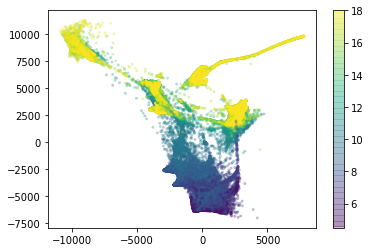

In [17]:
plt.scatter(adata_batch.obsm["X_fle"].x, adata_batch.obsm["X_fle"].y, c = adata_batch.obs.day, s = 4, alpha = 0.25)
plt.colorbar()

In [18]:
adata_batch.obs = adata_batch.obs.drop(columns = ["MET", "OPC", "Astrocyte", "Neuron", "SpongioTropho", "ProgenitorTropho", "SpiralArteryTrophoGiant", "RadialGlia"])

In [19]:
adata_batch.obs.loc[:, "None"] = (adata_batch.obs.iloc[:, 3:].sum(1) == 0)
adata_batch = adata_batch[adata_batch.obs.iloc[:, 3:].sum(1) == 1, :]

In [20]:
# Ignore OPC onward; ignore MET
# IPS, Stromal, Neural, Epi, Tropho

In [21]:
t_initial = 8
t_final = 14.5
numcells = 250
dt0 = 0.5
eps_eff = 0.1
eps_df = 0.025
lamda = 2.5e-3

In [22]:
adata_batch.obs.iloc[:, 3:].sum()

IPS             3676
Stromal        24448
Neural          4307
Epithelial     10465
Trophoblast     6079
None           25087
dtype: int64

In [27]:
adata_ts = adata_batch[~np.isnan(adata_batch.obs.day), :] 
pg.pca(adata_ts, n_components = 10, features = None)
t_map = np.array(adata_ts.obs.day.unique())
t_map = t_map[t_map >= t_initial]
t_map = t_map[t_map < t_final]
t_map.sort()


Trying to set attribute `.uns` of view, copying.


In [71]:
os.chdir("/zfs/users/syz/syz/reprogramming_batch/run_lamda_0.0025_dirichlet5")
out_all = []
for fname in glob.glob("*.out"):
    with open(fname, "rb") as f:
        out_all += [dill.load(f), ]

In [72]:
out_all = out_all[:25]
def kl_summary(out):
    props = out['props']
    props_gwot = out['props_gwot']
    props_subsamp = out['props_subsamp']
    p_null = np.array(props_subsamp).mean(0)
    kl_gwot = np.array([   KL(np.array(props[i]), np.array(props_gwot[i])) for i in range(len(props))])
    kl_subsamp = np.array([KL(np.array(props[i]), np.array(props_subsamp[i])) for i in range(len(props))])
    kl_null = np.array([   KL(np.array(props[i]), p_null) for i in range(len(props))])
    return kl_gwot, kl_subsamp, kl_null

In [73]:
kl_summ = np.array([np.array(kl_summary(out)) for out in out_all])

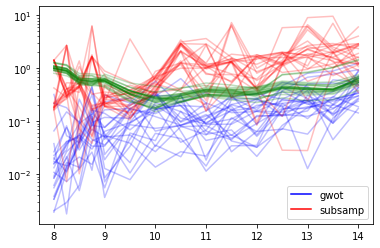

In [74]:
plt.plot(t_map, kl_summ[:, 0, :].T, color = "blue", alpha = 0.25, label = "gwot");
plt.plot(t_map, kl_summ[:, 1, :].T, color = "red", alpha = 0.25, label = "subsamp");
plt.plot(t_map, kl_summ[:, 2, :].T, color = "green", alpha = 0.25, label = "null");
plt.yscale("log")
leg = plt.legend(['gwot', 'subsamp'])
leg.legendHandles[0].set_color("blue")
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color("red")
leg.legendHandles[1].set_alpha(1)

Text(0.5, 1.0, '$\\lambda$ = 0.01')

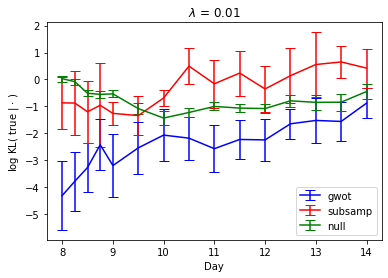

In [75]:
plt.errorbar(t_map, np.log(kl_summ).mean(0)[0, :].T, np.log(kl_summ).std(0)[0, :].T, color = "blue", alpha = 1, label = "gwot", capsize = 5);
plt.errorbar(t_map, np.log(kl_summ).mean(0)[1, :].T, np.log(kl_summ).std(0)[1, :].T, color = "red", alpha = 1, label = "subsamp", capsize = 5);
plt.errorbar(t_map, np.log(kl_summ).mean(0)[2, :].T, np.log(kl_summ).std(0)[2, :].T, color = "green", alpha = 1, label = "null", capsize = 5);
plt.legend()
plt.ylabel("log KL( true | $\cdot$ )")
plt.xlabel("Day")
plt.title("$\\lambda$ = 0.01")

(0.0, 2.0)

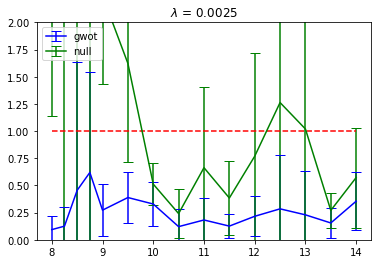

In [77]:
kl_ratio = (kl_summ[:, 0, :]/kl_summ[:, 1, :])
kl_null_ratio = (kl_summ[:, 2, :]/kl_summ[:, 1, :])
plt.errorbar(t_map, kl_ratio.mean(0), kl_ratio.std(0), color = "blue", label = "gwot", capsize = 5)
plt.errorbar(t_map, kl_null_ratio.mean(0), kl_null_ratio.std(0), color = "green", label = "null", capsize = 5)
plt.hlines(1, xmin = min(t_map), xmax = max(t_map), color = "red", linestyle = "dashed")
plt.legend()
plt.title("$\\lambda$ = 0.0025")
plt.ylim(0, 2)

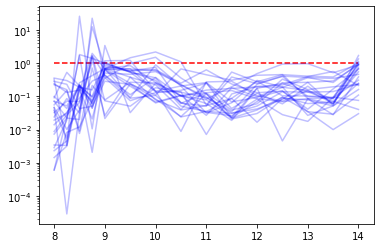

In [42]:
plt.plot(t_map, kl_ratio.T, color = "blue", alpha = 0.25);
plt.hlines(1, xmin = min(t_map), xmax = max(t_map), color = "red", linestyle = "dashed")
plt.yscale("log")

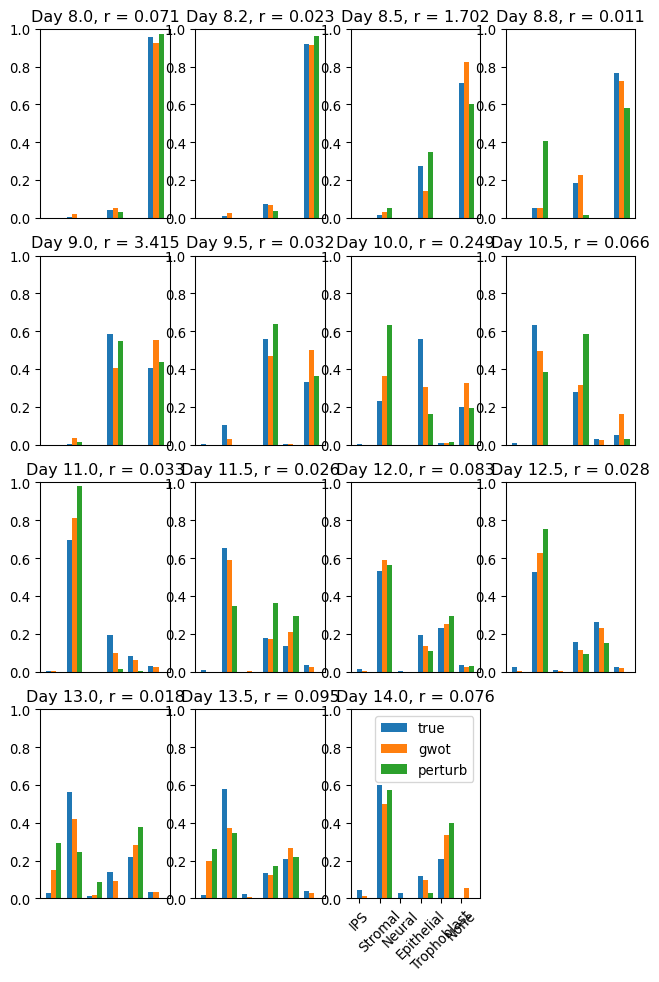

In [43]:
j = 0
props = out_all[j]["props"]
props_subsamp = out_all[j]["props_subsamp"]
props_gwot = out_all[j]["props_gwot"]

kl_gwot =    [KL(np.array(props[i]), np.array(props_gwot[i])) for i in range(len(props))]
kl_subsamp = [KL(np.array(props[i]), np.array(props_subsamp[i])) for i in range(len(props))]

plt.figure(figsize = (8, 12), dpi = 96)
for i in range(len(props)):
    plt.subplot(int(len(props)/4 + 0.5), 4, i+1)
    plt.title("Day %0.1f, r = %0.3f" % (t_map[i], kl_gwot[i]/kl_subsamp[i]))
    width = 0.25
    plt.bar(np.arange(len(props[i].index)), props[i], width = width, alpha = 1, label = "true")
    plt.bar(np.arange(len(props[i].index)) + width, props_gwot[i], width = width, alpha = 1, label = "gwot")
    plt.bar(np.arange(len(props[i].index)) + 2*width, props_subsamp[i], width = width, alpha = 1, label = "perturb")
    plt.ylim(0, 1)
    if i == len(props)-1:
        plt.xticks(np.arange(len(props[i].index)), props[i].index)
        plt.xticks(rotation = 45)
        plt.legend()
    else:
        plt.xticks([])